# Syed Muhammad Zain Computer Vision Deep Learning Model


## Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import *
from keras.utils import np_utils
from keras.optimizers import Adam
from tqdm import tqdm
import seaborn as sns
import numpy as np
import numpy as np
import pandas as pd
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis

In [3]:
Train_data1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CV emnist project/EMNIST data set/emnist-balanced-train.csv', header=None)

In [4]:
Train_data1.shape

(112800, 785)

In [5]:
#splitting data into xtrain and ytrain
trainingy=Train_data1[[0]]
trainingx=Train_data1.drop([0],axis=1)
print(trainingy.shape)
print(trainingx.shape)

(112800, 1)
(112800, 784)


In [6]:
#converting to series
trainingy=Train_data1[0]
trainingy.shape

(112800,)

In [7]:
mapping=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CV emnist project/EMNIST data set/emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)
mapping.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [8]:
mappingdict = {}
for i,L in enumerate(mapping):
    mappingdict[i] = chr(L)

mappingdict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [9]:
def correctingimage(imageforcorrection):
    imageforcorrection = imageforcorrection.reshape(28, 28)
    imageforcorrection = np.fliplr(imageforcorrection)
    imageforcorrection = np.rot90(imageforcorrection)
    return imageforcorrection

In [10]:
trainingx = np.apply_along_axis(correctingimage, 1, trainingx)
trainingx.shape

(112800, 28, 28)

In [11]:
#normalizing x and one hot encoding y both are not dataframes
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) #-1 means number of examples are undefined/unknown
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [12]:
trainingx=preprocess(trainingx)

In [13]:
print(trainingx.max(),trainingx.min())

1.0 -1.0


In [14]:
gopt = Adam(0.0001, 0.5)
dopt = Adam(0.0002, 0.5)
ND = 100


## Training and testing

In [15]:
from sklearn.model_selection import train_test_split
X_train_real,X_test_real,YT,YV = train_test_split(trainingx,trainingy,test_size=0.9,random_state=44)                                                

In [16]:
trainingx=X_train_real
trainingx.shape

(11280, 28, 28, 1)

In [17]:
def Gena():

    convmodel = Sequential()

    convmodel.add(Dense(4096, input_dim=ND))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(Activation("relu"))
    
    convmodel.add(Dense(98000, input_dim=ND))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(Activation("relu"))
    
    convmodel.add(Reshape((7, 7, 2000)))
    
    convmodel.add(UpSampling2D((2, 2)))
    convmodel.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    convmodel.add(BatchNormalization(momentum=0.8))
    convmodel.add(LeakyReLU(0.2))
    convmodel.add(UpSampling2D((2, 2)))
   
    convmodel.add(Conv2D(1, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return convmodel

In [18]:
def Disc():
    convmodel = Sequential()
    
    convmodel.add(Conv2D(64, (2, 2), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(28, 28, 1)))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Conv2D(128, (2, 2), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Flatten())
    
    convmodel.add(Dense(256))
    convmodel.add(Dense(128))
    convmodel.add(Dense(128))
    convmodel.add(LeakyReLU(0.2))
    
    convmodel.add(Dropout(0.5))
    convmodel.add(Dense(1, activation='sigmoid'))
    
    convmodel.compile(loss='binary_crossentropy', optimizer=dopt)
    return convmodel

In [19]:
G = Gena()
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 98000)             401506000 
_________________________________________________________________
batch_normalization_1 (Batch (None, 98000)             392000    
_________________________________________________________________
activation_1 (Activation)    (None, 98000)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 2000)        0

In [20]:
D= Disc()
D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [21]:
noisegenerated = Input(shape=(ND,))
fake_data_generated = G(noisegenerated )
D.trainable = False
OUTPUT1 = D(fake_data_generated)
DCGAN=Model(noisegenerated , OUTPUT1)
DCGAN.compile(loss='binary_crossentropy', optimizer=gopt)
 





In [22]:
FN= np.random.normal(0, 1, size=(30, ND))


In [23]:
def show_results(title, epoch):
    imgs = G.predict(FN)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((28,28)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 15)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [25]:
epochs = 201
batch_size = 128
steps_per_epoch = len(trainingx)//batch_size

current epouch is:  0
discriminator loss currently is :  0.5807034969329834
generator loss currently is:  0.9777072668075562
--------------------------------------------------------------------------------


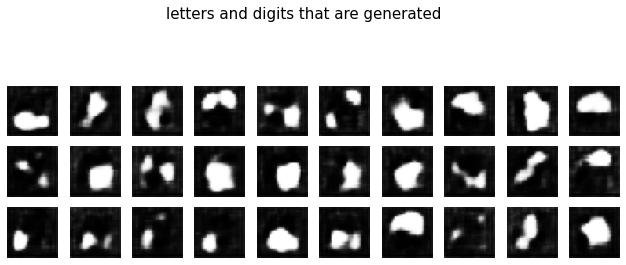

current epouch is:  1
discriminator loss currently is :  0.6463684439659119
generator loss currently is:  0.7162601351737976
--------------------------------------------------------------------------------
current epouch is:  2
discriminator loss currently is :  0.6848582625389099
generator loss currently is:  0.7590621709823608
--------------------------------------------------------------------------------
current epouch is:  3
discriminator loss currently is :  0.6754141449928284
generator loss currently is:  0.7917702198028564
--------------------------------------------------------------------------------
current epouch is:  4
discriminator loss currently is :  0.6634736657142639
generator loss currently is:  0.6337153315544128
--------------------------------------------------------------------------------
current epouch is:  5
discriminator loss currently is :  0.6660757660865784
generator loss currently is:  0.6478710770606995
---------------------------------------------------

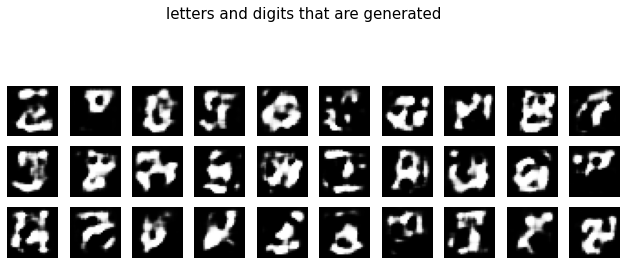

current epouch is:  6
discriminator loss currently is :  0.6795915365219116
generator loss currently is:  0.8885914087295532
--------------------------------------------------------------------------------
current epouch is:  7
discriminator loss currently is :  0.6717978119850159
generator loss currently is:  0.7913161516189575
--------------------------------------------------------------------------------
current epouch is:  8
discriminator loss currently is :  0.6256386637687683
generator loss currently is:  0.850487470626831
--------------------------------------------------------------------------------
current epouch is:  9
discriminator loss currently is :  0.706773042678833
generator loss currently is:  0.7705815434455872
--------------------------------------------------------------------------------
current epouch is:  10
discriminator loss currently is :  0.6797292828559875
generator loss currently is:  1.1008234024047852
----------------------------------------------------

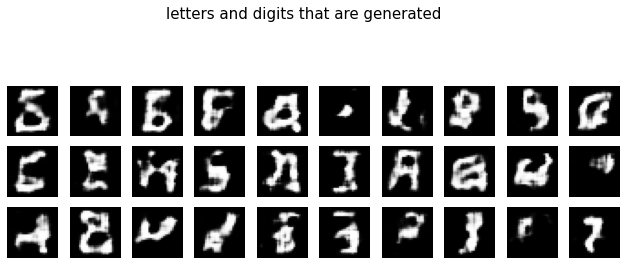

current epouch is:  11
discriminator loss currently is :  0.6828405857086182
generator loss currently is:  0.7109781503677368
--------------------------------------------------------------------------------
current epouch is:  12
discriminator loss currently is :  0.6780703663825989
generator loss currently is:  0.7356932759284973
--------------------------------------------------------------------------------
current epouch is:  13
discriminator loss currently is :  0.6337510943412781
generator loss currently is:  0.8236901760101318
--------------------------------------------------------------------------------
current epouch is:  14
discriminator loss currently is :  0.6615993976593018
generator loss currently is:  0.8044255971908569
--------------------------------------------------------------------------------
current epouch is:  15
discriminator loss currently is :  0.6776636242866516
generator loss currently is:  0.8888791799545288
----------------------------------------------

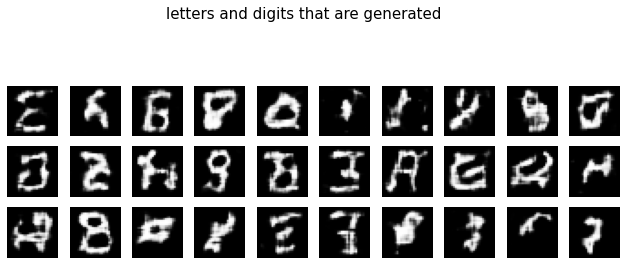

current epouch is:  16
discriminator loss currently is :  0.6308406591415405
generator loss currently is:  0.7760736346244812
--------------------------------------------------------------------------------
current epouch is:  17
discriminator loss currently is :  0.6570025086402893
generator loss currently is:  0.8332940340042114
--------------------------------------------------------------------------------
current epouch is:  18
discriminator loss currently is :  0.6431785821914673
generator loss currently is:  0.847057580947876
--------------------------------------------------------------------------------
current epouch is:  19
discriminator loss currently is :  0.6481378078460693
generator loss currently is:  0.5917779207229614
--------------------------------------------------------------------------------
current epouch is:  20
discriminator loss currently is :  0.6540545225143433
generator loss currently is:  0.8632174134254456
-----------------------------------------------

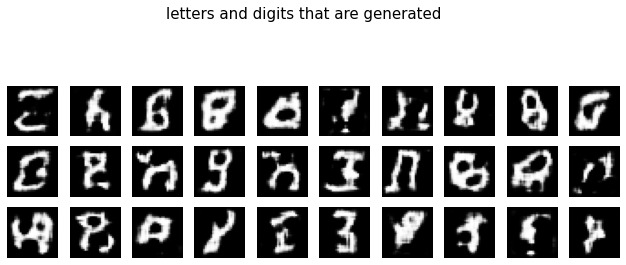

current epouch is:  21
discriminator loss currently is :  0.6483981609344482
generator loss currently is:  0.7800547480583191
--------------------------------------------------------------------------------
current epouch is:  22
discriminator loss currently is :  0.6438592076301575
generator loss currently is:  0.8447004556655884
--------------------------------------------------------------------------------
current epouch is:  23
discriminator loss currently is :  0.6332555413246155
generator loss currently is:  0.8511697053909302
--------------------------------------------------------------------------------
current epouch is:  24
discriminator loss currently is :  0.6289178133010864
generator loss currently is:  0.7589685916900635
--------------------------------------------------------------------------------
current epouch is:  25
discriminator loss currently is :  0.6230500936508179
generator loss currently is:  0.6072037816047668
----------------------------------------------

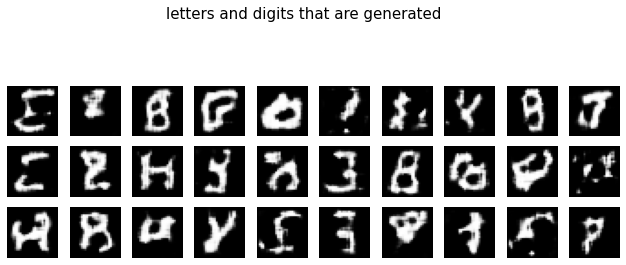

current epouch is:  26
discriminator loss currently is :  0.6070185899734497
generator loss currently is:  0.7295646667480469
--------------------------------------------------------------------------------
current epouch is:  27
discriminator loss currently is :  0.6276535987854004
generator loss currently is:  0.7089438438415527
--------------------------------------------------------------------------------
current epouch is:  28
discriminator loss currently is :  0.6506162285804749
generator loss currently is:  0.8744370937347412
--------------------------------------------------------------------------------
current epouch is:  29
discriminator loss currently is :  0.616564154624939
generator loss currently is:  0.8241736888885498
--------------------------------------------------------------------------------
current epouch is:  30
discriminator loss currently is :  0.7092096209526062
generator loss currently is:  0.9391111135482788
-----------------------------------------------

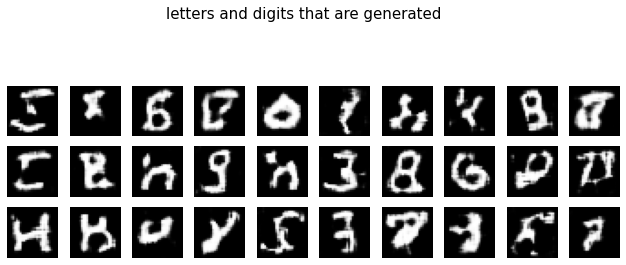

current epouch is:  31
discriminator loss currently is :  0.6245119571685791
generator loss currently is:  0.7234556674957275
--------------------------------------------------------------------------------
current epouch is:  32
discriminator loss currently is :  0.7060072422027588
generator loss currently is:  1.0004246234893799
--------------------------------------------------------------------------------
current epouch is:  33
discriminator loss currently is :  0.6681954264640808
generator loss currently is:  0.7429644465446472
--------------------------------------------------------------------------------
current epouch is:  34
discriminator loss currently is :  0.6028925180435181
generator loss currently is:  0.9179117679595947
--------------------------------------------------------------------------------
current epouch is:  35
discriminator loss currently is :  0.6298099160194397
generator loss currently is:  0.9235327243804932
----------------------------------------------

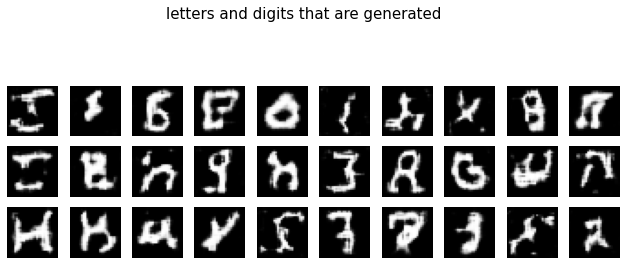

current epouch is:  36
discriminator loss currently is :  0.6149557828903198
generator loss currently is:  0.7946218252182007
--------------------------------------------------------------------------------
current epouch is:  37
discriminator loss currently is :  0.6098315715789795
generator loss currently is:  0.8935731649398804
--------------------------------------------------------------------------------
current epouch is:  38
discriminator loss currently is :  0.7038512229919434
generator loss currently is:  0.8231658339500427
--------------------------------------------------------------------------------
current epouch is:  39
discriminator loss currently is :  0.6675850749015808
generator loss currently is:  0.6853355169296265
--------------------------------------------------------------------------------
current epouch is:  40
discriminator loss currently is :  0.7009997367858887
generator loss currently is:  0.9943360090255737
----------------------------------------------

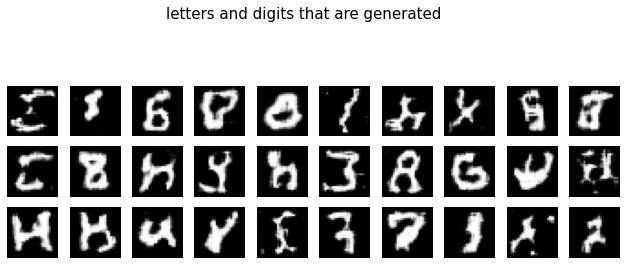

current epouch is:  41
discriminator loss currently is :  0.6003204584121704
generator loss currently is:  0.9118035435676575
--------------------------------------------------------------------------------
current epouch is:  42
discriminator loss currently is :  0.6036010980606079
generator loss currently is:  0.9877797961235046
--------------------------------------------------------------------------------
current epouch is:  43
discriminator loss currently is :  0.6039716005325317
generator loss currently is:  0.6149533987045288
--------------------------------------------------------------------------------
current epouch is:  44
discriminator loss currently is :  0.6152254939079285
generator loss currently is:  0.8413439989089966
--------------------------------------------------------------------------------
current epouch is:  45
discriminator loss currently is :  0.6570997834205627
generator loss currently is:  0.6734393835067749
----------------------------------------------

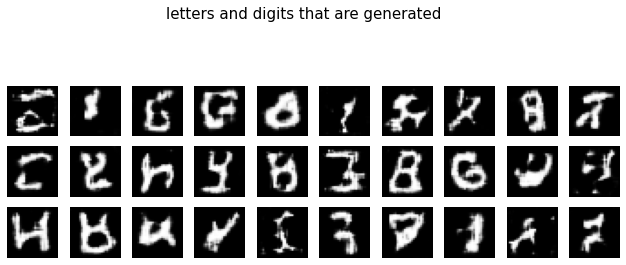

current epouch is:  46
discriminator loss currently is :  0.5850253701210022
generator loss currently is:  0.7211672067642212
--------------------------------------------------------------------------------
current epouch is:  47
discriminator loss currently is :  0.6207797527313232
generator loss currently is:  0.9729795455932617
--------------------------------------------------------------------------------
current epouch is:  48
discriminator loss currently is :  0.6339125037193298
generator loss currently is:  1.2784955501556396
--------------------------------------------------------------------------------
current epouch is:  49
discriminator loss currently is :  0.6132605671882629
generator loss currently is:  0.6992484331130981
--------------------------------------------------------------------------------
current epouch is:  50
discriminator loss currently is :  0.6173990368843079
generator loss currently is:  0.7690342664718628
----------------------------------------------

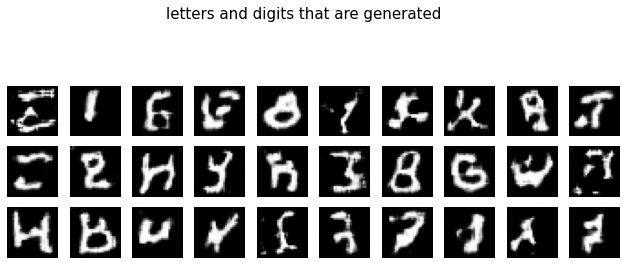

current epouch is:  51
discriminator loss currently is :  0.6471825838088989
generator loss currently is:  1.023258924484253
--------------------------------------------------------------------------------
current epouch is:  52
discriminator loss currently is :  0.611046314239502
generator loss currently is:  0.9289795160293579
--------------------------------------------------------------------------------
current epouch is:  53
discriminator loss currently is :  0.5946922898292542
generator loss currently is:  0.7417981624603271
--------------------------------------------------------------------------------
current epouch is:  54
discriminator loss currently is :  0.6694082021713257
generator loss currently is:  0.943096935749054
--------------------------------------------------------------------------------
current epouch is:  55
discriminator loss currently is :  0.6064189076423645
generator loss currently is:  0.8816375732421875
-------------------------------------------------

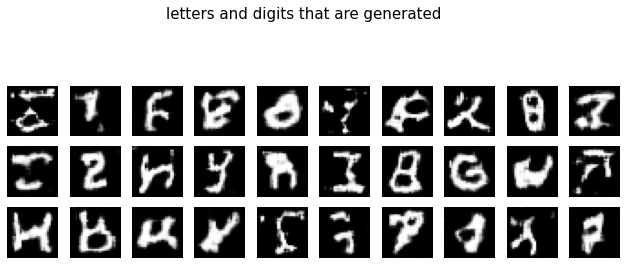

current epouch is:  56
discriminator loss currently is :  0.6246662735939026
generator loss currently is:  1.0796968936920166
--------------------------------------------------------------------------------
current epouch is:  57
discriminator loss currently is :  0.6186960935592651
generator loss currently is:  0.8391244411468506
--------------------------------------------------------------------------------
current epouch is:  58
discriminator loss currently is :  0.5953977108001709
generator loss currently is:  0.8019702434539795
--------------------------------------------------------------------------------
current epouch is:  59
discriminator loss currently is :  0.6193038821220398
generator loss currently is:  0.7092554569244385
--------------------------------------------------------------------------------
current epouch is:  60
discriminator loss currently is :  0.6143836379051208
generator loss currently is:  0.86427903175354
------------------------------------------------

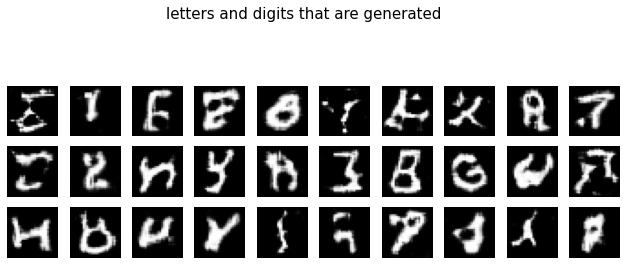

current epouch is:  61
discriminator loss currently is :  0.5981694459915161
generator loss currently is:  0.6005964875221252
--------------------------------------------------------------------------------
current epouch is:  62
discriminator loss currently is :  0.608098566532135
generator loss currently is:  0.6465862989425659
--------------------------------------------------------------------------------
current epouch is:  63
discriminator loss currently is :  0.5860792994499207
generator loss currently is:  0.7423118352890015
--------------------------------------------------------------------------------
current epouch is:  64
discriminator loss currently is :  0.5955405235290527
generator loss currently is:  1.034398078918457
--------------------------------------------------------------------------------
current epouch is:  65
discriminator loss currently is :  0.6550954580307007
generator loss currently is:  1.3242887258529663
------------------------------------------------

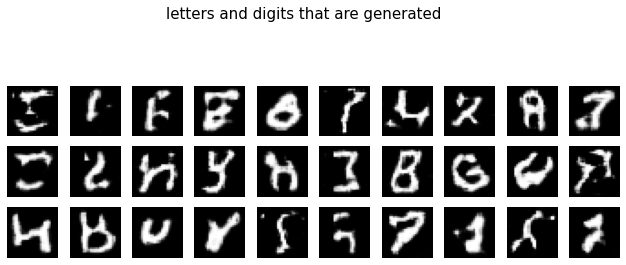

current epouch is:  66
discriminator loss currently is :  0.6115618944168091
generator loss currently is:  0.9027549028396606
--------------------------------------------------------------------------------
current epouch is:  67
discriminator loss currently is :  0.5953260064125061
generator loss currently is:  0.8675152659416199
--------------------------------------------------------------------------------
current epouch is:  68
discriminator loss currently is :  0.6109466552734375
generator loss currently is:  1.104968786239624
--------------------------------------------------------------------------------
current epouch is:  69
discriminator loss currently is :  0.5928168892860413
generator loss currently is:  0.8504190444946289
--------------------------------------------------------------------------------
current epouch is:  70
discriminator loss currently is :  0.6031495928764343
generator loss currently is:  0.9127501249313354
-----------------------------------------------

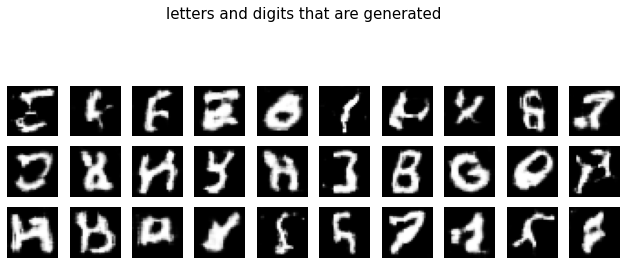

current epouch is:  71
discriminator loss currently is :  0.6270976662635803
generator loss currently is:  0.9232867956161499
--------------------------------------------------------------------------------
current epouch is:  72
discriminator loss currently is :  0.5866748690605164
generator loss currently is:  0.8616926074028015
--------------------------------------------------------------------------------
current epouch is:  73
discriminator loss currently is :  0.5733064413070679
generator loss currently is:  1.1046087741851807
--------------------------------------------------------------------------------
current epouch is:  74
discriminator loss currently is :  0.6110865473747253
generator loss currently is:  1.0657601356506348
--------------------------------------------------------------------------------
current epouch is:  75
discriminator loss currently is :  0.6050221920013428
generator loss currently is:  0.8504302501678467
----------------------------------------------

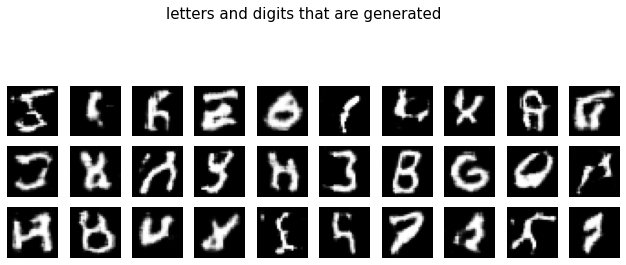

current epouch is:  76
discriminator loss currently is :  0.6045775413513184
generator loss currently is:  0.6088038682937622
--------------------------------------------------------------------------------
current epouch is:  77
discriminator loss currently is :  0.5866723656654358
generator loss currently is:  0.7907118201255798
--------------------------------------------------------------------------------
current epouch is:  78
discriminator loss currently is :  0.6314660310745239
generator loss currently is:  0.9472714066505432
--------------------------------------------------------------------------------
current epouch is:  79
discriminator loss currently is :  0.5699343681335449
generator loss currently is:  0.9809932112693787
--------------------------------------------------------------------------------
current epouch is:  80
discriminator loss currently is :  0.5904514193534851
generator loss currently is:  0.9289214611053467
----------------------------------------------

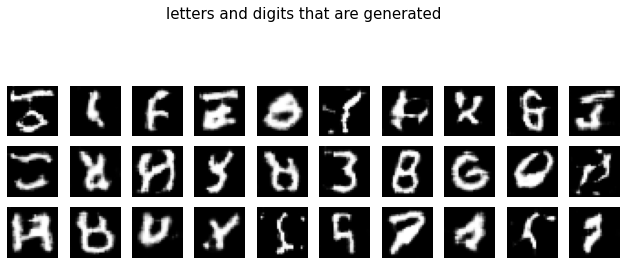

In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        inputgenerator = np.random.normal(0, 1, size=(batch_size, ND))
        fakedataG = G.predict(inputgenerator)
        realdataG = trainingx[np.random.randint(0, trainingx.shape[0], size=batch_size)]
        realdataG = realdataG.reshape((batch_size, 28, 28, 1))
        inputdiscriminator= np.concatenate((realdataG , fakedataG))
        labeldiscriminator = np.zeros(2*batch_size)
        labeldiscriminator[:batch_size] = 0.9
        labeldiscriminator[batch_size:] = 0.1
        lossdiscriminator= D.train_on_batch(inputdiscriminator, labeldiscriminator)
        labelgenerator= np.ones(batch_size)
        lossgenerator = DCGAN.train_on_batch(inputgenerator, labelgenerator)

    print("current epouch is: ", epoch)
    print("discriminator loss currently is : ", lossdiscriminator)
    print("generator loss currently is: ", lossgenerator)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_results("letters and digits that are generated", epoch)